# Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from collections import OrderedDict
from abc import ABC, abstractmethod
from sklearn.datasets import load_diabetes

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Реализуем градиентный бустинг

In [2]:
def train_test_split(*arrays,
                     random_state=None,
                     train_size=None,
                     test_size=None,
                     shuffle=True):
    results = []

    if train_size is None:
        if test_size is None:
            test_size = 0.25

        train_size = 1 - test_size

    train_size = max(train_size, 0)
    train_size = min(train_size, 1)
    indexes = np.arange(len(arrays[0]))

    if random_state is not None:
        np.random.seed(int(random_state))

    if shuffle:
        np.random.shuffle(indexes)

    idx = ceil(len(indexes) * train_size)
    train_idx = indexes[:idx]
    test_idx = indexes[idx:]
    for arr in arrays:
        array = np.array(arr)
        results.append(array[train_idx, ...])
        results.append(array[test_idx, ...])

    return results

### Реализация дерева из прошлых методичек

In [3]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [4]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    def predict(self, X):
        if X[self.index] <= self.t:
            return self.true_branch.predict(X)
        else:
            return self.false_branch.predict(X)

In [5]:
class Leaf(ABC):
    def __init__(self, labels):
        self.labels = labels
        self._get_prediction(labels)

    def predict(self, X=None):
        return self.prediction

    @abstractmethod
    def _get_prediction(self, labels):
        self.prediction = None

In [6]:
class DecisionTree(ABC):

    def __init__(self,
                 max_depth=None,
                 max_features=None,
                 min_samples_leaf=1,
                 max_leaf_count=None,
                 min_impurity_decrease=0.0):

        self._tree = None
        self._leaf_count = 0

        self._max_features = max_features
        self._min_samples_leaf = min_samples_leaf
        self._max_leaf_count = max_leaf_count
        self._min_impurity_decrease = min_impurity_decrease

        if max_depth is None:
            self._max_depth = inf
        else:
            self._max_depth = max(max_depth - 1, 0)

        if type(self._max_features) is str:
            allowed_feat = ['sqrt',]
            self._max_features = self._max_features.lower()
            if self._max_features not in allowed_feat:
                raise ValueError(
                    f"Unknown value {self._max_features} for max_features!"
                )

    @abstractmethod
    def _criterion(self, labels):
        pass

    @abstractmethod
    def _Leaf(self, labels):
        pass

    @abstractmethod
    def _Node(self, index, t, true_branch, false_branch):
        pass

    def __str__(self):
        return self._print_tree(self._tree)

    def fit(self, X, y):
        self._leaf_count = 0
        self._tree = self._build_tree(X, y)

        if self._max_leaf_count is not None:
            n = self._leaf_count - self._max_leaf_count
            if n > 0:
                cutter = TreeCutter()
                self._tree = cutter.cut_leafs(self._tree, n)

    def predict(self, X):
        return np.apply_along_axis(self._tree.predict, 1, np.array(X))

    def _build_tree(self, data, labels, level=0):
        gain, t, index = self._find_best_split(data, labels)

        stop_flag = False
        stop_flag = stop_flag or gain == 0
        stop_flag = stop_flag or gain < self._min_impurity_decrease
        stop_flag = stop_flag or level > self._max_depth

        if stop_flag:
            self._leaf_count += 1
            return self._Leaf(labels)

        true_data, false_data, true_labels, false_labels = self._split(
            data, labels, index, t
        )

        true_branch = self._build_tree(true_data, true_labels, level+1)
        false_branch = self._build_tree(false_data, false_labels, level+1)
        return self._Node(index, t, true_branch, false_branch)

    def _find_best_split(self, data, labels):
        best_gain, best_t, best_index = 0, None, None

        h = self._criterion(labels)
        for index in self._get_features(data.shape[1]):

            for t in np.unique(data[:, index]):
                _, _, left_labels, right_labels = self._split(
                    data, labels, index, t
                )

                if len(left_labels) < self._min_samples_leaf:
                    continue

                if len(right_labels) < self._min_samples_leaf:
                    continue

                p = len(left_labels) / len(labels)
                left_h = self._criterion(left_labels)
                right_h = self._criterion(right_labels)
                current_gein = h - (p * left_h) - ((1 - p) * right_h)

                if current_gein > best_gain:
                    best_gain, best_t, best_index = current_gein, t, index

        return best_gain, best_t, best_index

    def _split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]

    def _get_features(self, data_len):
        if self._max_features is None:
            n_feat = data_len

        elif type(self._max_features) is str:
            if self._max_features == 'sqrt':
                n_feat = int(np.sqrt(data_len))

        elif type(self._max_features) is float:
            n_feat = int(data_len * self._max_features)

        else:
            n_feat = int(self._max_features)

        n_feat = max(n_feat, 1)
        n_feat = min(n_feat, data_len)

        indexes = np.arange(data_len)
        np.random.shuffle(indexes)
        return indexes[:n_feat]

    def _print_tree(self, node, spacing=""):
        text = ''

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            text += ColorText.ORANGE + spacing + ' ЛИСТ'
            text += ': прогноз = ' + str(node.prediction)
            text += ', объектов = ' + str(len(node.labels))
            text += ColorText.END
            return text

        # Выведем значение индекса и порога на этом узле
        text += ColorText.GREEN + spacing + 'УЗЕЛ'
        text += ': индекс = ' + str(node.index)
        text += ', порог = ' + str(round(node.t, 2))
        text += ColorText.END

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Левая ветка:\n'
        text += self._print_tree(node.true_branch, spacing + "   ")

        # Рекурсионный вызов функции на положительном поддереве
        text += f'\n{spacing}--> Правая ветка:\n'
        text += self._print_tree(node.false_branch, spacing + "   ")

        return text


In [7]:
class TreeCutter:

    def cut_leafs(self, tree, n, cut_last_node=False):
        self._level_list = OrderedDict()
        self._read_node(tree)
        n = self._cut_leafs(n)
        if n > 0 and cut_last_node:
            leaf = self._create_leaf_from_node(tree)
            if leaf is not None:
                return leaf

        return tree

    def _read_node(self, node, parent=None, level=0):
        if isinstance(node, Node):
            self._add_node(node, parent, level)

            if isinstance(node.true_branch, Node):
                self._read_node(node.true_branch, node, level+1)

            if isinstance(node.false_branch, Node):
                self._read_node(node.false_branch, node, level+1)

    def _add_node(self, node, parent, level):
        if level not in self._level_list:
            self._level_list[level] = []

        self._level_list[level].append((node, parent))

    def _cut_leafs(self, n):
        while n > 0 and len(self._level_list):
            _, level = self._level_list.popitem()

            while n > 0 and len(level):
                node, parent = level.pop()
                if not isinstance(parent, Node):
                    continue

                leaf = self._create_leaf_from_node(node)
                if leaf is not None:
                    n -= self._replace_node_by_leaf(parent, node, leaf)

        return n

    def _create_leaf_from_node(self, node):
        cut_node = True
        cut_node = cut_node and isinstance(node.true_branch, Leaf)
        cut_node = cut_node and isinstance(node.false_branch, Leaf)

        if cut_node:
            true_labels = node.true_branch.labels
            false_labels = node.false_branch.labels
            labels = np.hstack((true_labels, false_labels))
            return type(node.true_branch)(labels)

        return None

    def _replace_node_by_leaf(self, parent, node, leaf):
        if parent.true_branch is node:
            parent.true_branch = leaf
            return 1

        elif parent.false_branch is node:
            parent.false_branch = leaf
            return 1

        return 0

In [8]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [9]:
class RegressorLeaf(Leaf):

    def _get_prediction(self, labels):
        self.prediction = np.mean(labels)


class DecisionTreeRegressor(DecisionTree):

    def __init__(self, criterion='mse', **kwargs):
        super().__init__(**kwargs)

        criterion = criterion.lower()
        criterion_list = ['mse', 'mae']
        if criterion == 'mse':
            self._selected_criterion = mse

        elif criterion == 'mae':
            self._selected_criterion = mae

        else:
            error = f'Unknown criterion {criterion} for DecisionTreeClassifier'
            error += f' (criterion not in [{", ".join(criterion_list)}])!'
            raise ValueError(error)

    def _criterion(self, labels):
        return self._selected_criterion(labels, np.mean(labels))

    def _Leaf(self, labels):
        return RegressorLeaf(labels)

    def _Node(self, index, t, true_branch, false_branch):
        return Node(index, t, true_branch, false_branch)

### Реализация бустинга

In [10]:
class BoostingRegressor:

    def __init__(self,
                 estimator=None,
                 eta=0.1,
                 n_estimators=100,
                 random_state=None,
                 estimator_coefs=None,
                 subsample=1.0,
                 **kwargs) -> None:

        self._estimators = []
        self._base_prediction = None

        self._eta = eta
        self._estimator = estimator
        self._n_estimators = n_estimators
        self._random_state = random_state
        self._estimator_coefs = estimator_coefs
        self._subsample = subsample
        self._estimator_args = kwargs

        self._train_errors = []
        self._test_errors = []

    def _bias(self, X, y):
        z = self.predict(X)
        return -2 * (z - y)

    def fit(self, X, y, X_test=None, y_test=None):
        self._train_errors = []
        self._test_errors = []
        
        np.random.seed(self._random_state)
        X, y = np.array(X), np.array(y)

        if self._estimator_coefs is None:
            self._estimator_coefs = np.ones(self._n_estimators)

        for _ in range(self._n_estimators):
            estimator = self._estimator(**self._estimator_args)

            data = train_test_split(X, y, train_size=self._subsample)
            X_train, _, y_train, _ = data
            
            if len(self._estimators) == 0:
                estimator.fit(X_train, y_train)
            else:
                estimator.fit(X_train, self._bias(X_train, y_train))

            self._estimators.append(estimator)

            self._train_errors.append(mse(self.predict(X), y))
            if X_test is not None and y_test is not None:
                self._test_errors.append(mse(self.predict(X_test), y_test))

    def predict(self, X):
        y_pred = []
        for estimator, coef in zip(self._estimators, self._estimator_coefs):
            y_pred.append(self._eta * coef * estimator.predict(X))

        y_pred = np.array(y_pred).T
        y_pred = y_pred.sum(axis=1)

        return y_pred
    
    def plot(self, label):
        iterations = list(range(self._n_estimators))

        plt.subplot(2, 1, 1)
        plt.plot(iterations,
                 self._train_errors,
                 label=label + f'mse = ({self._train_errors[-1]})')
        plt.xlabel('Trees count')
        plt.ylabel('MSE')
        plt.title('Train')
        plt.legend(loc='upper right')

        if self._test_errors:
            plt.subplot(2, 1, 2)
            plt.plot(iterations,
                     self._test_errors,
                     label=label + f'; mse = ({self._test_errors[-1]})')
            plt.xlabel('Trees count')
            plt.ylabel('MSE')
            plt.title('Test')
            plt.legend(loc='upper right')

In [11]:
class GradientBoostingRegressor(BoostingRegressor):

    def __init__(self,
                 estimator=None,
                 eta=0.1,
                 n_estimators=100,
                 random_state=None,
                 estimator_coefs=None,
                 subsample=1.0,
                 **kwargs) -> None:

        if estimator is None:
            estimator = DecisionTreeRegressor

        super().__init__(estimator=estimator,
                         eta=eta,
                         n_estimators=n_estimators,
                         random_state=random_state,
                         estimator_coefs=estimator_coefs,
                         subsample=subsample,
                         **kwargs)

## Посмотрим как работает модель

In [12]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

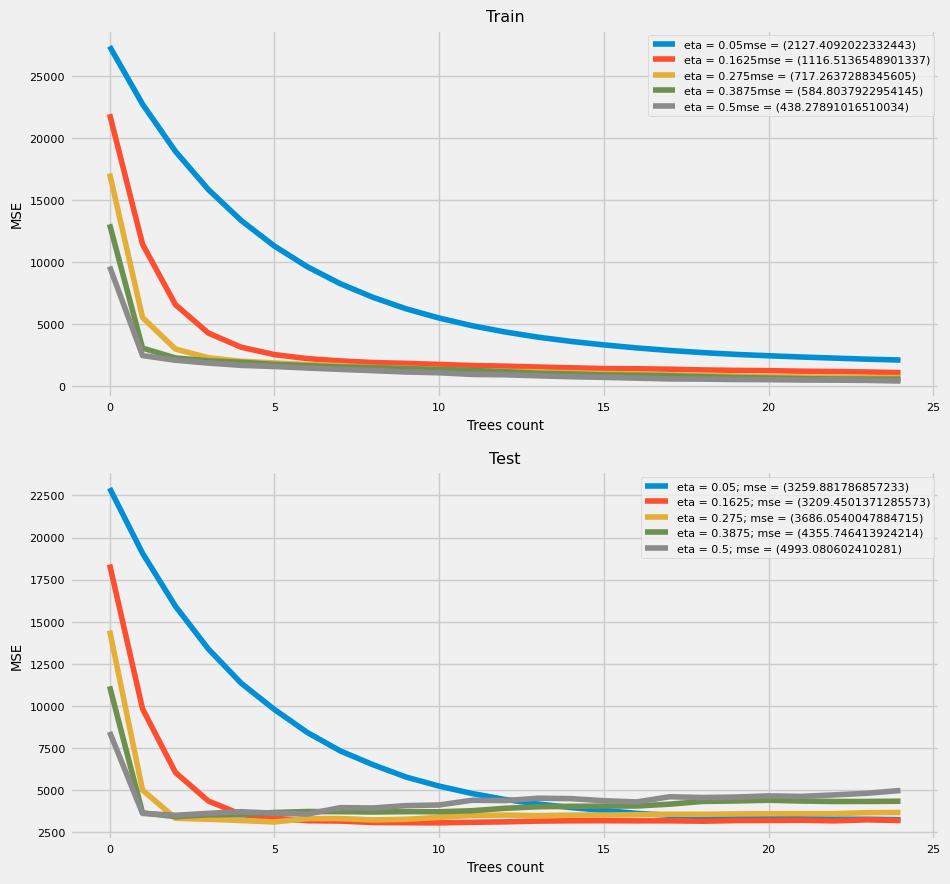

In [13]:
plt.figure(figsize=[10, 10])

max_depth = 3
for eta in np.linspace(0.05, 0.5, 5):
    gb = GradientBoostingRegressor(n_estimators=25, max_depth=max_depth, eta=eta)
    gb.fit(X_train, y_train, X_test, y_test)
    gb.plot(f'eta = {eta}')

plt.show()

При увеличчении скорости обучения алгоритм начинает сходиться быстрее, но и переобучение начинается раньше.

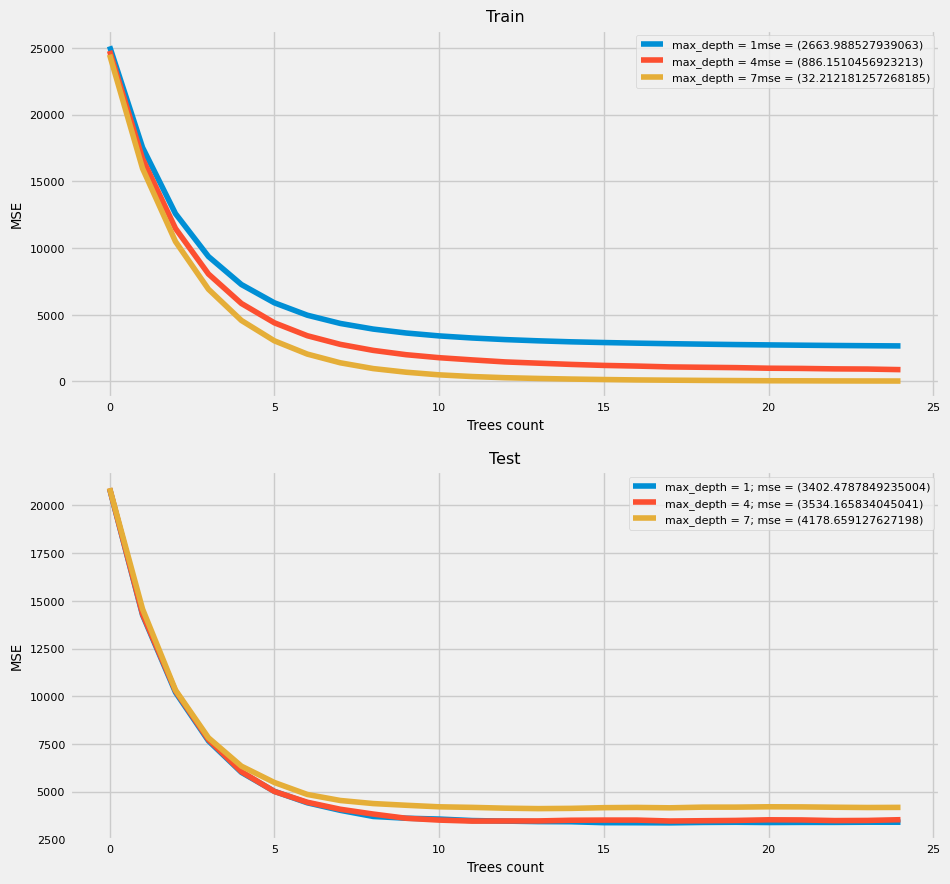

In [14]:
plt.figure(figsize=[10, 10])

eta = 0.1
for max_depth in range(1, 10, 3):
    gb = GradientBoostingRegressor(n_estimators=25, max_depth=max_depth, eta=eta)
    gb.fit(X_train, y_train, X_test, y_test)
    gb.plot(f'max_depth = {max_depth}')

plt.show()

При увеличении глубины модель раньше переобучается.
Для получения наилучших результатов следует делать низкую скорость обучения при малой глубине и большом количестве деревьев, но выполняться это будет значительно дольше.

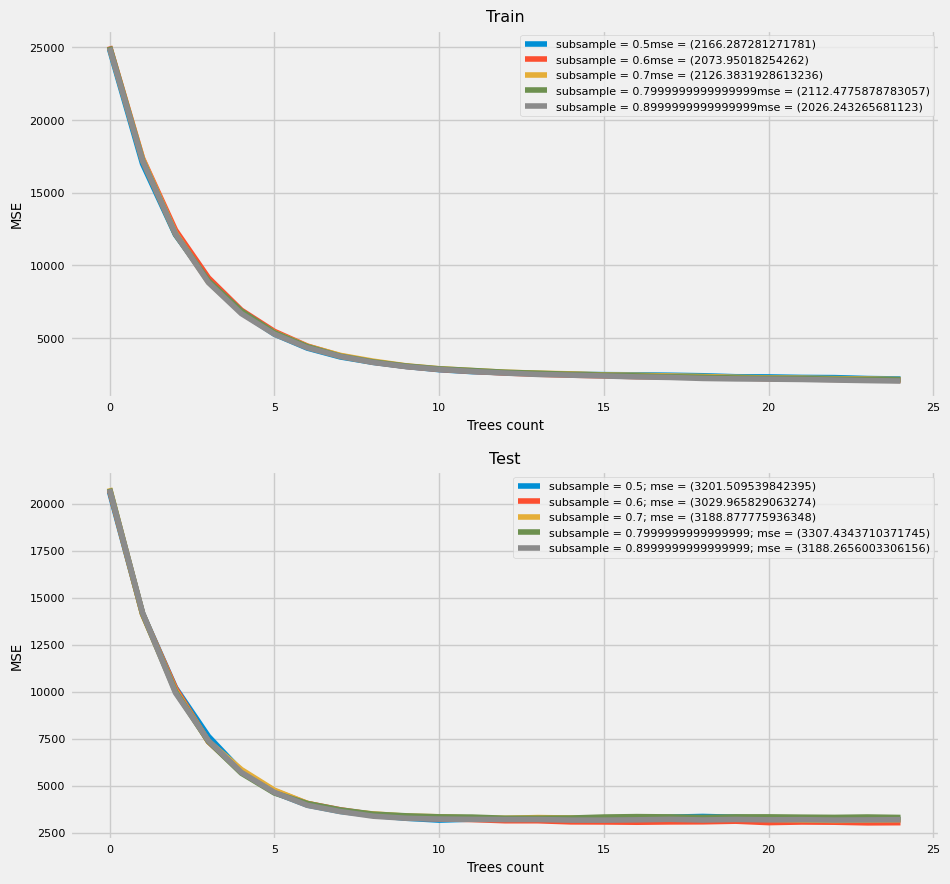

In [15]:
plt.figure(figsize=[10, 10])

eta = 0.1
max_depth = 2
for subsample in np.arange(0.5, 1, 0.1):
    gb = GradientBoostingRegressor(n_estimators=25, max_depth=max_depth, eta=eta, subsample=subsample)
    gb.fit(X_train, y_train, X_test, y_test)
    gb.plot(f'subsample = {subsample}')

plt.show()

Уменьшение подвыборки для обучения (стохастическая реализация) может снизить переобучение модели.